In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns 


## inspired by

https://www.kaggle.com/lilsummer877/visualize-the-effect-of-events-and-festivities

modified to investigate whether events influence sales on days leading up to that event...

In [11]:
# read data (for now, sell_prices & calendar are not used)

data_dir = '../code/data/'

train_sales = pd.read_csv(data_dir + 'sales_train_validation.csv')
sell_prices = pd.read_csv(data_dir + 'sell_prices.csv')
calendar = pd.read_csv(data_dir + 'calendar.csv')
submission_file = pd.read_csv(data_dir + 'sample_submission.csv')

In [13]:
calendar['event_true_1'] = calendar.event_name_1.notna()
calendar['event_true_2'] = calendar.event_name_2.notna()

calendar['event_true_all'] = calendar.event_true_1 + calendar.event_true_2
calendar['event_true_all'] = calendar.event_true_all.apply(lambda x: x>0)
calendar['event_true_all'] = calendar.event_true_all.astype('int')
calendar['date'] = pd.to_datetime(calendar.date)

events_series = pd.Series(calendar.event_true_all.values, index=calendar.date)

/home/chb3k/anaconda3/envs/py37ismi/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [15]:
calendar['event_name_all'] = calendar.event_name_1.fillna('') + '_' +calendar.event_name_2.fillna('')
calendar['event_name_all'] = calendar.event_name_all.apply(lambda x: x[:-1] if x[len(x)-1] == '_' else x)

In [16]:
d_list = calendar[calendar.event_true_all==1].d.values
year_list = calendar[calendar.event_true_all == 1].year.values
name_list = calendar[calendar.event_true_all == 1].event_name_all


In [17]:
d_list = calendar[calendar.event_true_all==1].d.values
year_list = calendar[calendar.event_true_all == 1].year.values
name_list = calendar[calendar.event_true_all == 1].event_name_all

barplot_pd = pd.DataFrame({'Year': year_list, 'd': d_list, 'Name': name_list}).reset_index()

In [18]:
barplot_pd=barplot_pd[:154]

In [23]:
def get_daily_average(d, dep):
    return train_sales[train_sales.dept_id==dep][d].mean()

In [62]:
## we think dat the days preceding an event will have more sales than days not preceding an event
def get_daily_average_altered(d, dep):

    actual_day = d.split('_')[1]
    start_day = int(actual_day) - 1
    d_start_day = 'd_' + str(start_day)
    return train_sales[train_sales.dept_id==dep][d_start_day].mean()

In [63]:
for dept in train_sales.dept_id.unique():
    barplot_pd[dept] = barplot_pd.d.apply(lambda x: get_daily_average_altered(x, dept))

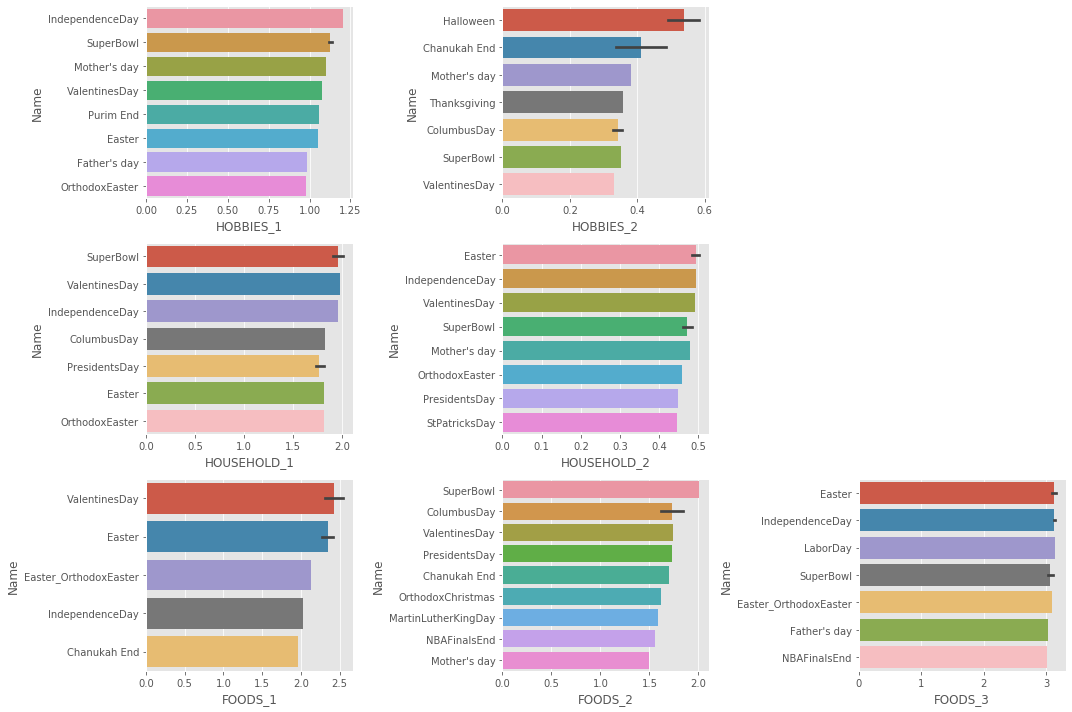

In [96]:
f, axes = plt.subplots(3,3, figsize=(15,10))

barplot_pd = barplot_pd.sort_values('HOBBIES_1', ascending=False)
sns.barplot(barplot_pd.HOBBIES_1[:10], barplot_pd.Name[:10], ax=axes[0,0])
barplot_pd = barplot_pd.sort_values('HOBBIES_2', ascending=False)
sns.barplot(barplot_pd.HOBBIES_2[:10], barplot_pd.Name[:10], ax=axes[0,1])
barplot_pd = barplot_pd.sort_values('HOUSEHOLD_1', ascending=False)
sns.barplot(barplot_pd.HOUSEHOLD_1[:10], barplot_pd.Name[:10], ax=axes[1,0])
barplot_pd = barplot_pd.sort_values('HOUSEHOLD_2', ascending=False)
sns.barplot(barplot_pd.HOUSEHOLD_2[:10], barplot_pd.Name[:10], ax=axes[1,1])
barplot_pd = barplot_pd.sort_values('FOODS_1', ascending=False)
sns.barplot(barplot_pd.FOODS_1[:10], barplot_pd.Name[:10], ax=axes[2,0])
barplot_pd = barplot_pd.sort_values('FOODS_2', ascending=False)
sns.barplot(barplot_pd.FOODS_2[:10], barplot_pd.Name[:10], ax=axes[2,1])
barplot_pd = barplot_pd.sort_values('FOODS_3', ascending=False)
sns.barplot(barplot_pd.FOODS_3[:10], barplot_pd.Name[:10], ax=axes[2,2])

f.delaxes(axes[0][2])
f.delaxes(axes[1][2])

plt.tight_layout()

In [65]:
group_calendar = calendar[calendar.date < pd.datetime(2016, 4, 25)].groupby(['year', 'event_true_all', 'event_name_all'])\
.agg({'d': lambda x: list(x)})\
.reset_index()

/home/chb3k/anaconda3/envs/py37ismi/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [84]:
def get_avg_year_value(d_list):
    if(len(d_list) == 1):
        d = d_list[0]
        actual_day = d.split('_')[1]
        start_day = int(actual_day) - 1
        d_start_day = 'd_' + str(start_day)
        d_list = [d_start_day]
        
    my_dict = dict((d,'mean') for d in d_list)
    all_means = train_sales.groupby('cat_id').agg(my_dict).values
    return all_means.mean()

In [85]:
group_calendar['avg_sale_unit'] = group_calendar.d.apply(lambda x: get_avg_year_value(x))

In [86]:
joined_group_calendar = \
group_calendar[group_calendar.event_true_all==1]\
.merge(group_calendar[group_calendar.event_true_all==0][['year', 'avg_sale_unit']]\
.rename({'avg_sale_unit': 'non_event_avg_sale_unit'}, axis=1), on='year')

In [87]:
joined_group_calendar['ratio'] = joined_group_calendar.avg_sale_unit / joined_group_calendar.non_event_avg_sale_unit

In [88]:
plt.style.use('ggplot')
plot_pd_1 = joined_group_calendar\
.groupby('event_name_all').agg({'ratio': 'mean'}, axis=1).sort_values('ratio', ascending=False)

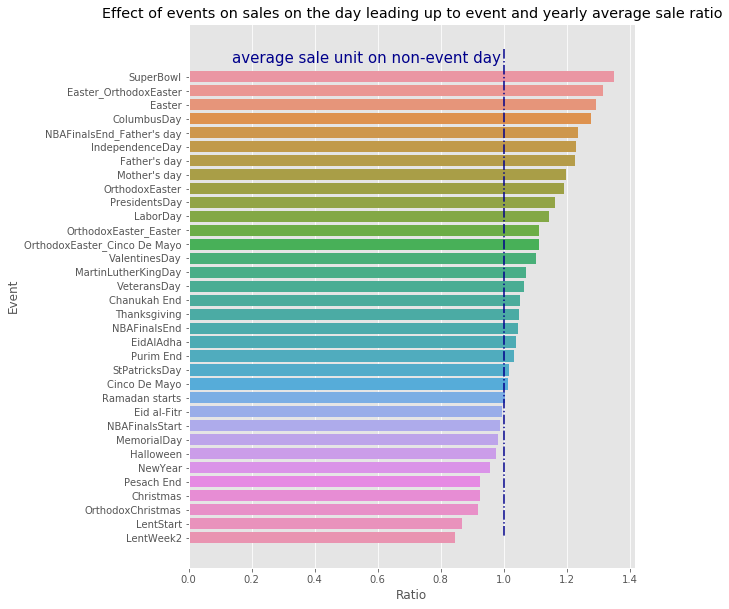

In [94]:
plt.figure(figsize=(8,10))
sns.barplot(x=plot_pd_1.ratio, y=plot_pd_1.index)
plt.vlines(x=1, ymin=-2, ymax=33, linestyles='-.', color='darkblue')
plt.text(0.99, -0.8, 'average sale unit on non-event day',
        verticalalignment='bottom', horizontalalignment='right',
        color='darkblue', fontsize=15)
plt.title("Effect of events on sales on the day leading up to event and yearly average sale ratio")
plt.xlabel("Ratio")
plt.ylabel("Event")
plt.show()

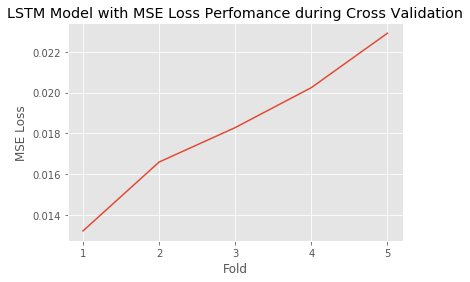

In [103]:
## plots of CrossValidation LSTM with MSE LOSS
## had to pull these from WandB
evaluations_folds = [0.01321,0.01659,0.01828,0.02024,0.02291]
folds = [1,2,3,4,5]


plt.plot(folds,evaluations_folds)
plt.xticks(folds)

plt.xlabel("Fold")
plt.ylabel("MSE Loss")
plt.title("LSTM Model with MSE Loss Perfomance during Cross Validation")

plt.show()







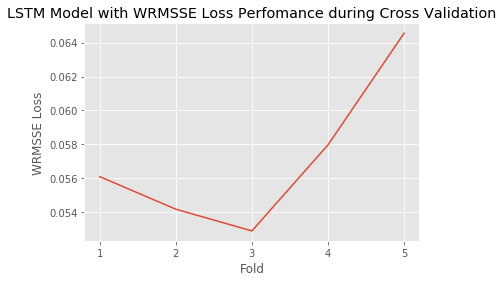

In [104]:
## plots of CrossValidation LSTM with WRMSSE LOSS
## had to pull these from WandB
evaluations_folds = [0.05610,0.05418,0.05290,0.05797,0.06455]
folds = [1,2,3,4,5]


plt.plot(folds,evaluations_folds)
plt.xticks(folds)
plt.xlabel("Fold")
plt.ylabel("WRMSSE Loss")
plt.title("LSTM Model with WRMSSE Loss Perfomance during Cross Validation")
plt.show()


